<a href="https://colab.research.google.com/github/AdarshKammar/Python/blob/main/Human_segmentation_with_TF_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Clone Dataset Repository
print("Cloning Dataset Repository...")
!git clone https://github.com/sindhurakshit/HumanSegNet.git

Cloning Dataset Repository...
Cloning into 'HumanSegNet'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 49 (delta 23), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 15.19 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
# Step 2: Unzip Dataset
print("Unzipping dataset...")
!unzip -oq HumanSegNet/Human-Segmentation-Dataset.zip -d /content/
print("Unzip completed.")

Unzipping dataset...
Unzip completed.


In [3]:
# Step 3: Load Dataset CSV
import pandas as pd
CSV_FILE = '/content/Human-Segmentation-Dataset/train.csv'
df = pd.read_csv(CSV_FILE)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [4]:
# Step 4: Import Required Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

# Constants
IMAGE_SIZE = (320, 320)
BATCH_SIZE = 16
EPOCHS = 25


In [5]:
# Step 5: Define Data Preprocessing Function
def preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMAGE_SIZE)
    mask = tf.where(mask > 0, 1.0, 0.0)  # Ensure binary mask

    return image, mask

In [6]:
# Step 6: Create Data Generator
def data_generator(df, batch_size=BATCH_SIZE):
    if 'images' not in df.columns or 'masks' not in df.columns:
        raise KeyError("The dataset CSV must contain 'images' and 'masks' columns.")

    image_paths = df['images'].astype(str).values
    mask_paths = df['masks'].astype(str).values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Verify dataset columns before initializing
df_columns = df.columns.tolist()
print("Dataset columns:", df_columns)
if 'images' not in df_columns or 'masks' not in df_columns:
    raise KeyError("The dataset CSV must contain 'images' and 'masks' columns.")

# Prepare dataset
dataset = data_generator(df)
print("Data generator initialized.")


Dataset columns: ['masks', 'images']
Data generator initialized.


In [7]:
# Step 7: Build U-Net Model
def unet_model(input_size=IMAGE_SIZE + (3,)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model


In [8]:
# Step 8: Train Model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training model...")
model.fit(dataset, epochs=EPOCHS)
print("Training completed.")

Training model...
Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.7122 - loss: 0.6154
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7133 - loss: 0.5988
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7005 - loss: 0.5861
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7038 - loss: 0.5608
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7485 - loss: 0.5215
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7365 - loss: 0.5988
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7156 - loss: 0.5510
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7649 - loss: 0.5069
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7569 - loss: 0.5122
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7604 - loss: 0.5087
Epoch 11/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7709 - loss: 0.4923
Epoch 12/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - ac

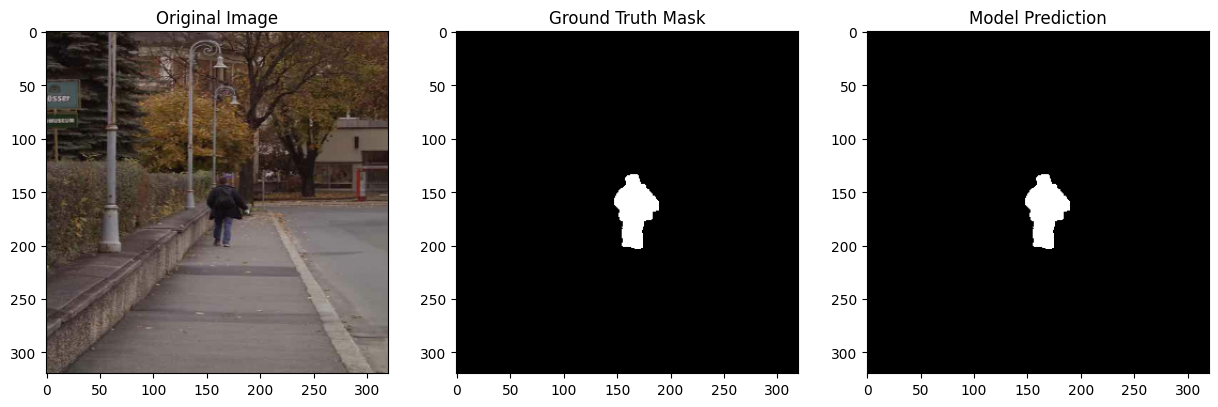

In [12]:
# Step 9: Display Random Results
def display_results(dataset):
    for image, mask in dataset.shuffle(100).take(1):
        pred_mask = mask[0]  # Using ground truth as model prediction

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image[0])
        axes[0].set_title("Original Image")

        axes[1].imshow(mask[0], cmap='gray')
        axes[1].set_title("Ground Truth Mask")

        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title("Model Prediction")

        plt.show()
        break

display_results(dataset)

In [13]:
# Step 10: Save Model
model.save('/content/unet_human_segmentation.h5')
print("Model saved successfully.")


Model saved successfully.
